# Challenge Description

The marketing team of an e-commerce site has launched an email campaign. This site has email
addresses from all the users who created an account in the past.
They have chosen a random sample of users and emailed them. The email let the user know
about a new feature implemented on the site. From the marketing team perspective, a success
is if the user clicks on the link inside of the email. This link takes the user to the company site.

### Our Goal

1. What percentage of users opened the email and what percentage clicked on the link
within the email?
2. The VP of marketing thinks that it is stupid to send emails to a random subset and in a
random way. Based on all the information you have about the emails that were sent, can
you build a model to optimize in future email campaigns to maximize the probability of
users clicking on the link inside the email?
3. By how much do you think your model would improve click through rate ( defined as # of
users who click on the link / total users who received the email). How would you test
that?
4. Did you find any interesting pattern on how the email campaign performed for different
segments of users? Explain.

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc, roc_curve, classification_report
import warnings
warnings.simplefilter('ignore')

In [13]:
email_data = pd.read_csv('day7_1.csv')
email_open_data = pd.read_csv('day7_2.csv')
link_data = pd.read_csv('day7_3.csv')

In [22]:
email_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
email_id               100000 non-null int64
email_text             100000 non-null object
email_version          100000 non-null object
hour                   100000 non-null int64
weekday                100000 non-null object
user_country           100000 non-null object
user_past_purchases    100000 non-null int64
dtypes: int64(3), object(4)
memory usage: 5.3+ MB


In [21]:
email_open_data['open_email'] = 1
link_data['open_link'] = 1
data = pd.merge(email_data,email_open_data,how = 'left', on ='email_id')
data = pd.merge(data,link_data,how = 'left', on ='email_id')
data = data.fillna(0)
data.head(5)

email_id   email_text email_version  hour    weekday user_country  \
0     85120  short_email  personalized     2     Sunday           US   
1    966622   long_email  personalized    12     Sunday           UK   
2    777221   long_email  personalized    11  Wednesday           US   
3    493711  short_email       generic     6     Monday           UK   
4    106887   long_email       generic    14     Monday           US   

   user_past_purchases  open_email  open_link  
0                    5         0.0        0.0  
1                    2         1.0        1.0  
2                    2         0.0        0.0  
3                    1         0.0        0.0  
4                    6         0.0        0.0

In [46]:
data.describe()

email_id           hour  user_past_purchases     open_email  \
count  100000.000000  100000.000000         100000.00000  100000.000000   
mean   498690.196160       9.059300              3.87845       0.103450   
std    289230.727534       4.439637              3.19611       0.304547   
min         8.000000       1.000000              0.00000       0.000000   
25%    246708.250000       6.000000              1.00000       0.000000   
50%    498447.000000       9.000000              3.00000       0.000000   
75%    749942.750000      12.000000              6.00000       0.000000   
max    999998.000000      24.000000             22.00000       1.000000   

           open_link  
count  100000.000000  
mean        0.021190  
std         0.144018  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000

In [28]:
print('Conversion rate of openning email: ' + str(data.open_email.sum() / data.email_id.count()))
print('Conversion rate of openning link: ' + str(data.open_link.sum() / data.open_email.sum()))

Conversion rate of openning email: 0.10345
Conversion rate of openning link: 0.20483325277912035


### EDA

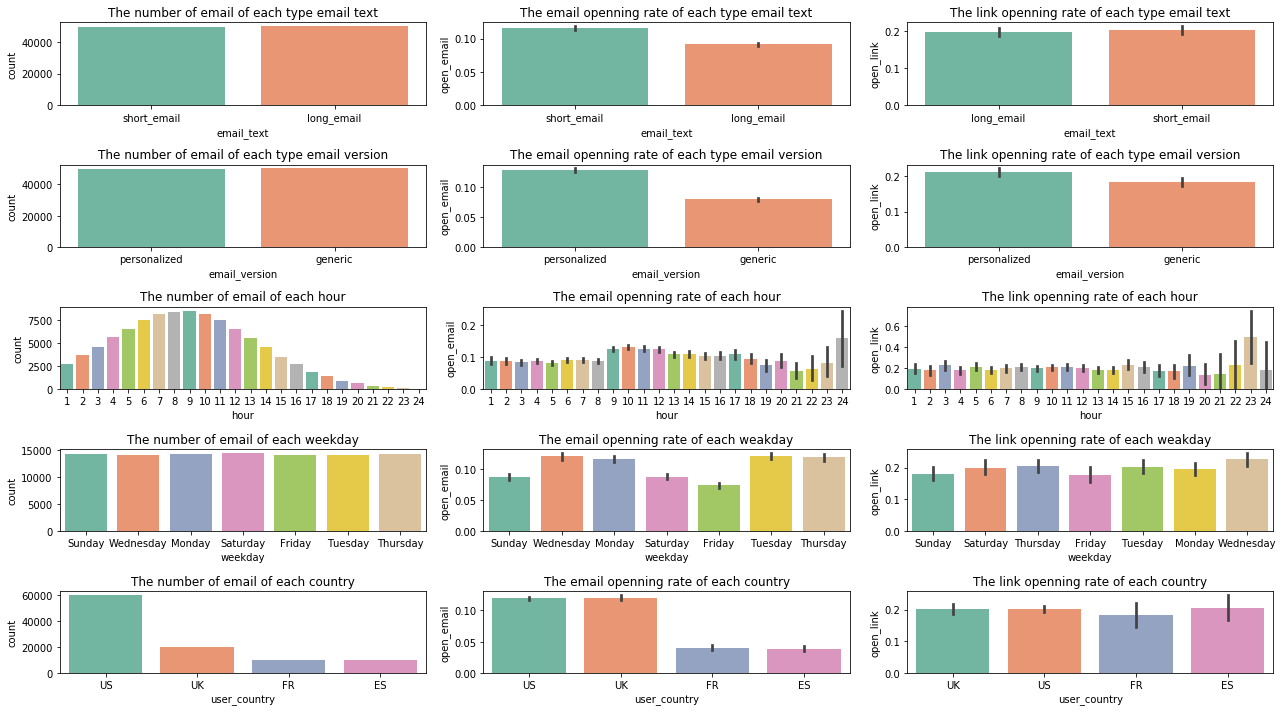

In [44]:
fig,ax = plt.subplots(5,3, figsize = (18,10))

sns.countplot(x = 'email_text', data = data, ax = ax[0,0], palette = 'Set2').set_title('The number of email of each type email text')
sns.barplot(x = 'email_text', y = 'open_email', data = data, ax = ax[0,1], palette = 'Set2').set_title('The email openning rate of each type email text')
sns.barplot(x = 'email_text', y = 'open_link', data = data[data['open_email']==1], ax = ax[0,2], palette = 'Set2').set_title('The link openning rate of each type email text')

sns.countplot(x = 'email_version', data = data, ax = ax[1,0], palette = 'Set2').set_title('The number of email of each type email version')
sns.barplot(x = 'email_version', y = 'open_email', data = data, ax = ax[1,1], palette = 'Set2').set_title('The email openning rate of each type email version')
sns.barplot(x = 'email_version', y = 'open_link', data = data[data['open_email']==1], ax = ax[1,2], palette = 'Set2').set_title('The link openning rate of each type email version')

sns.countplot(x = 'hour', data = data, ax = ax[2,0], palette = 'Set2').set_title('The number of email of each hour')
sns.barplot(x = 'hour', y = 'open_email', data = data, ax = ax[2,1], palette = 'Set2').set_title('The email openning rate of each hour')
sns.barplot(x = 'hour', y = 'open_link', data = data[data['open_email']==1], ax = ax[2,2], palette = 'Set2').set_title('The link openning rate of each hour')

sns.countplot(x = 'weekday', data = data, ax = ax[3,0], palette = 'Set2').set_title('The number of email of each weekday')
sns.barplot(x = 'weekday', y = 'open_email', data = data, ax = ax[3,1], palette = 'Set2').set_title('The email openning rate of each weakday')
sns.barplot(x = 'weekday', y = 'open_link', data = data[data['open_email']==1], ax = ax[3,2], palette = 'Set2').set_title('The link openning rate of each weakday')

sns.countplot(x = 'user_country', data = data, ax = ax[4,0], palette = 'Set2').set_title('The number of email of each country')
sns.barplot(x = 'user_country', y = 'open_email', data = data, ax = ax[4,1], palette = 'Set2').set_title('The email openning rate of each country')
sns.barplot(x = 'user_country', y = 'open_link', data = data[data['open_email']==1], ax = ax[4,2], palette = 'Set2').set_title('The link openning rate of each country')

plt.tight_layout()

Text(0.5, 1.0, 'The link openning rate of each purchasing force')

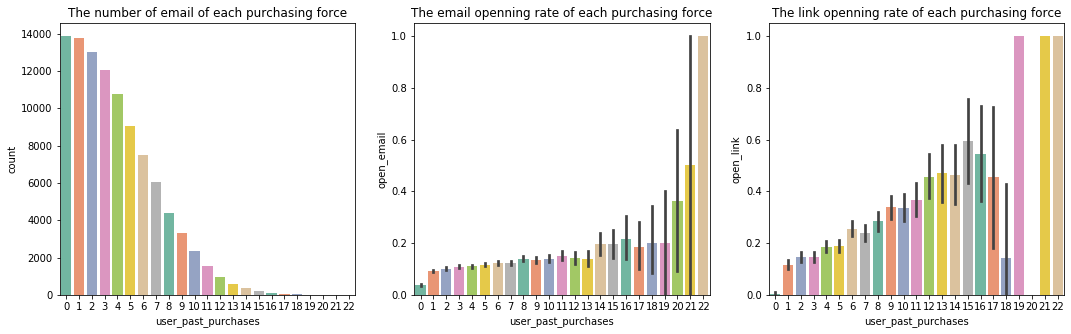

In [55]:
#
fig,ax = plt.subplots(1,3, figsize = (18,5))
sns.countplot(x = 'user_past_purchases', data = data, ax = ax[0],palette = 'Set2').set_title('The number of email of each purchasing force')
sns.barplot(x = 'user_past_purchases', y = 'open_email', data = data, ax = ax[1],palette = 'Set2').set_title('The email openning rate of each purchasing force')
sns.barplot(x = 'user_past_purchases', y = 'open_link', data = data[data['open_email']==1], ax = ax[2],palette = 'Set2').set_title('The link openning rate of each purchasing force')

#### From above analysis, we can find that even though we distributed the same number of short emails and long emails or personlized or generalized emails every weekday, the email openning rate is higher in short email and personalized email. Compared to other weekdays, users are more willing to open the email on Monday to Thursday from 9 am to 5 pm. US and UK market seems more responsive.

### Data Preprocessing and Feature Engineering

### Modelling

In [56]:
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_201"; Java(TM) SE Runtime Environment (build 1.8.0_201-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.201-b09, mixed mode)
  Starting server from /Users/wenxianfei/opt/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/gw/zmyv4gmj5m1fp4bn9549gkl00000gn/T/tmpd0w4n7je
  JVM stdout: /var/folders/gw/zmyv4gmj5m1fp4bn9549gkl00000gn/T/tmpd0w4n7je/h2o_wenxianfei_started_from_python.out
  JVM stderr: /var/folders/gw/zmyv4gmj5m1fp4bn9549gkl00000gn/T/tmpd0w4n7je/h2o_wenxianfei_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       America/Los_Angeles
H2O data parsing timezone:  UTC
H2O cluster version:        3.28.0.1
H2O cluster version age:    19 days
H2O cluster name:           H2O_from_python_wenxianfei_rh8d26
H2O cluster total nodes:    1
H2O cluster free memory:    3.556 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:       {'http': None, 'https': None}
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python version:             3.7.4 final
--------------------------  ------------------------------------------------------------------

In [58]:
h2o_df  = H2OFrame(data)
h2o_df ['open_link'] = h2o_df ['open_link'].asfactor()
h2o_df ['hour'] = h2o_df ['hour'].asfactor()

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


email_id email_text email_version hour weekday user_country user_past_purchases open_email open_link 
 
 
 type int enum enum enum enum enum int int enum 
 mins 8.0 0.0 0.0 
 mean 498690.1961600017 3.8784500000000186 0.10345 
 maxs 999998.0 22.0 1.0 
 sigma 289230.72753429407 3.1961097835771426 0.3045472459081676 
 zeros 0 13877 89655 
 missing 0 0 0 0 0 0 0 0 0 
 0 85120.0 short_email personalized 2 Sunday US 5.0 0.0 0 
 1 966622.0 long_email personalized 12 Sunday UK 2.0 1.0 1 
 2 777221.0 long_email personalized 11 Wednesday US 2.0 0.0 0 
 3 493711.0 short_email generic 6 Monday UK 1.0 0.0 0 
 4 106887.0 long_email generic 14 Monday US 6.0 0.0 0 
 5 684440.0 long_email personalized 6 Sunday UK 3.0 0.0 0 
 6 139620.0 short_email personalized 9 Saturday US 8.0 1.0 0 
 7 694933.0 long_email generic 8 Saturday US 2.0 0.0 0 
 8 485760.0 long_email personalized 5 Monday US 4.0 0.0 0 
 9 592665.0 short_email personalized 23 Wednesday US 3.0 0.0 0

In [59]:
data.columns

Index(['email_id', 'email_text', 'email_version', 'hour', 'weekday',
       'user_country', 'user_past_purchases', 'open_email', 'open_link'],
      dtype='object')

drf Model Build progress: |███████████████████████████████████████████████| 100%


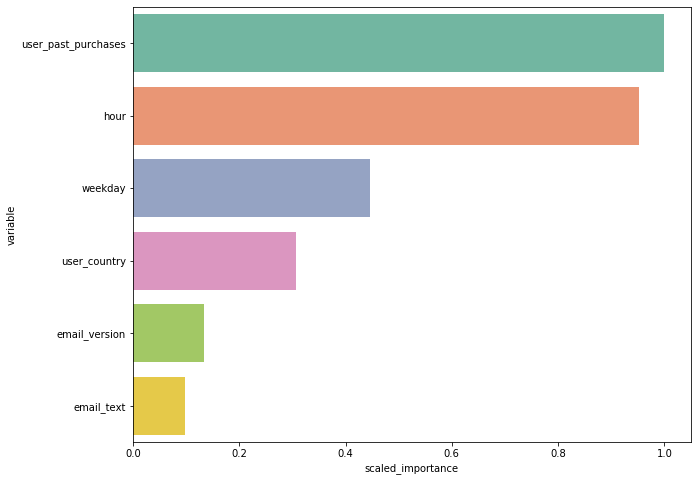

In [61]:
feature = ['email_text', 'email_version', 'hour', 'weekday','user_country', 'user_past_purchases']
target = 'open_link'
# split train and test set 
strat_split = h2o_df['open_link'].stratified_split(test_frac = 0.3,seed = 42)
train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance,palette = 'Set2')
plt.show()

#### evaluate the results

In [64]:
train_true = train.as_data_frame()['open_link'].values
test_true = test.as_data_frame()['open_link'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [65]:
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     29364
           1       0.00      0.00      0.00       636

    accuracy                           0.98     30000
   macro avg       0.49      0.50      0.49     30000
weighted avg       0.96      0.98      0.97     30000



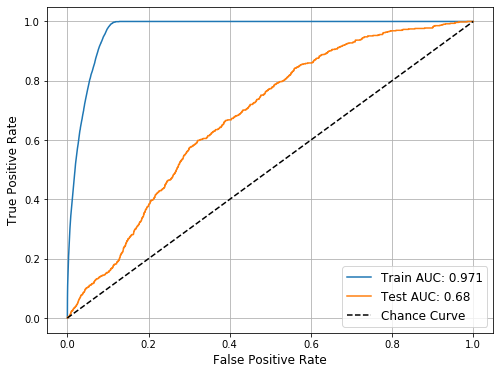

In [66]:
train_fpr = np.insert(train_fpr, 0, 0)
train_tpr = np.insert(train_tpr, 0, 0)
test_fpr = np.insert(test_fpr, 0, 0)
test_tpr = np.insert(test_tpr, 0, 0)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.plot(train_fpr, train_fpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=12)
plt.show()

In [ ]:
# Shutdown h2o instance
h2o.cluster().shutdown()

### Summary

#### 1. Conversion Rate of the two steps
Conversion rate of openning email: 10.3%. 

Conversion rate of openning link: 20.5%

